In [1]:
import numpy as np
import pandas as pd

# for Scaling , Encoding and Polinomial features for Hidden paterns:
from sklearn.preprocessing import StandardScaler , OneHotEncoder , PolynomialFeatures 
from sklearn.feature_selection import SelectKBest , f_classif # for classification

# for Imputing na :
from sklearn.impute import SimpleImputer

# for Pipeline Creationa and transformimg.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# test case split and Cross validation for right hyper parmeter
from sklearn.model_selection import train_test_split , GridSearchCV


# models to perform predictions:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
import xgboost
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB

#For Dimentionality Reduction and as model:
from sklearn.decomposition import PCA

# Metrics to calculate Classification type traget:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix , f1_score

# for Charts and graph
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

import warnings
warnings.filterwarnings("ignore")

## EDA

In [2]:
data = pd.read_csv("heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.shape

(918, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
## No Missing value , but we have objects


In [6]:
# Clean column names (remove extra whitespace, if any)
data.columns = data.columns.str.strip()

In [7]:
data.duplicated().sum()

0

In [8]:
# No duplicates

In [9]:
data.groupby(['HeartDisease','Sex'])['Age'].count()


HeartDisease  Sex
0             F      143
              M      267
1             F       50
              M      458
Name: Age, dtype: int64

In [10]:
# Genderwise the Data is scewed

In [11]:
((data.value_counts('Sex',normalize=True))*100).round(2)

Sex
M    78.98
F    21.02
Name: proportion, dtype: float64

<Axes: xlabel='HeartDisease', ylabel='count'>

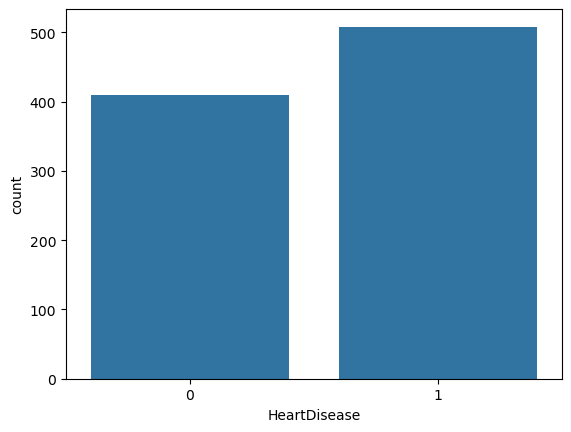

In [12]:
sns.barplot(data.value_counts('HeartDisease'))
## Target is some what balanced

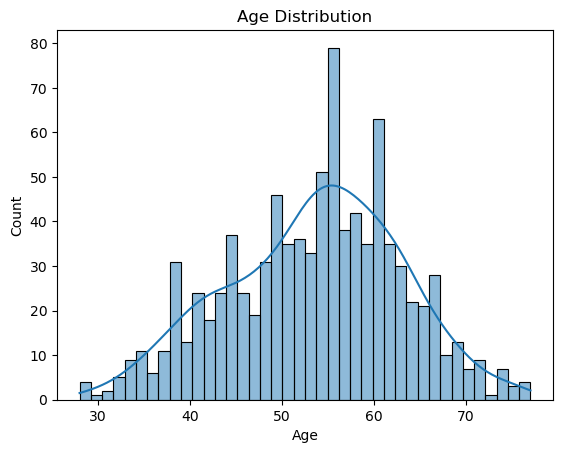

In [13]:
sns.histplot(data['Age'], bins=40, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()

<Axes: >

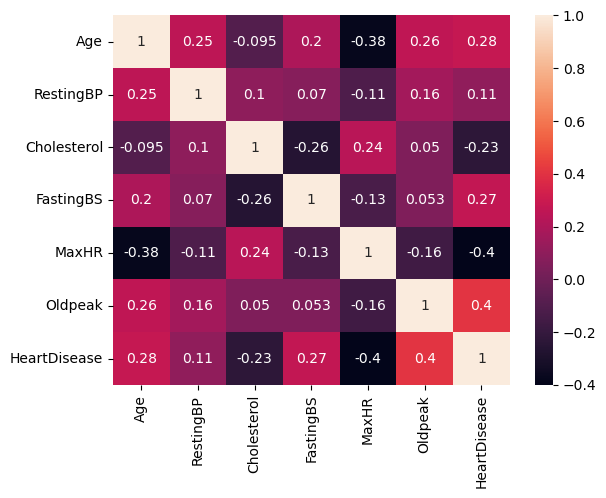

In [14]:
#plt.figure(figsize=(8, 8))
numeric_cols = data.select_dtypes(include=['number']).columns
sns.heatmap(data[numeric_cols].corr(), annot=True)

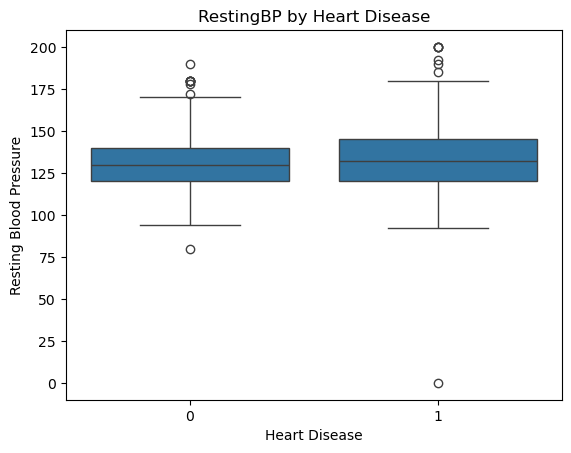

In [15]:
sns.boxplot(x='HeartDisease', y='RestingBP', data=data)
plt.title("RestingBP by Heart Disease")
plt.xlabel("Heart Disease")
plt.ylabel("Resting Blood Pressure")
plt.show()

In [16]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [17]:
data.groupby(['ChestPainType','HeartDisease'])['HeartDisease'].count()

ChestPainType  HeartDisease
ASY            0               104
               1               392
ATA            0               149
               1                24
NAP            0               131
               1                72
TA             0                26
               1                20
Name: HeartDisease, dtype: int64

In [18]:
print(data['ExerciseAngina'].value_counts(normalize=True),'\n')
print(data.groupby('ExerciseAngina')['HeartDisease'].count(),'\n')
print((data.groupby(['ExerciseAngina','HeartDisease'])['HeartDisease']).size())

ExerciseAngina
N    0.595861
Y    0.404139
Name: proportion, dtype: float64 

ExerciseAngina
N    547
Y    371
Name: HeartDisease, dtype: int64 

ExerciseAngina  HeartDisease
N               0               355
                1               192
Y               0                55
                1               316
Name: HeartDisease, dtype: int64


In [19]:
data.groupby(['ExerciseAngina','HeartDisease']).size().reset_index(name='count')

,ExerciseAngina,HeartDisease,count
0,N,0,355
1,N,1,192
2,Y,0,55
3,Y,1,316


In [20]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

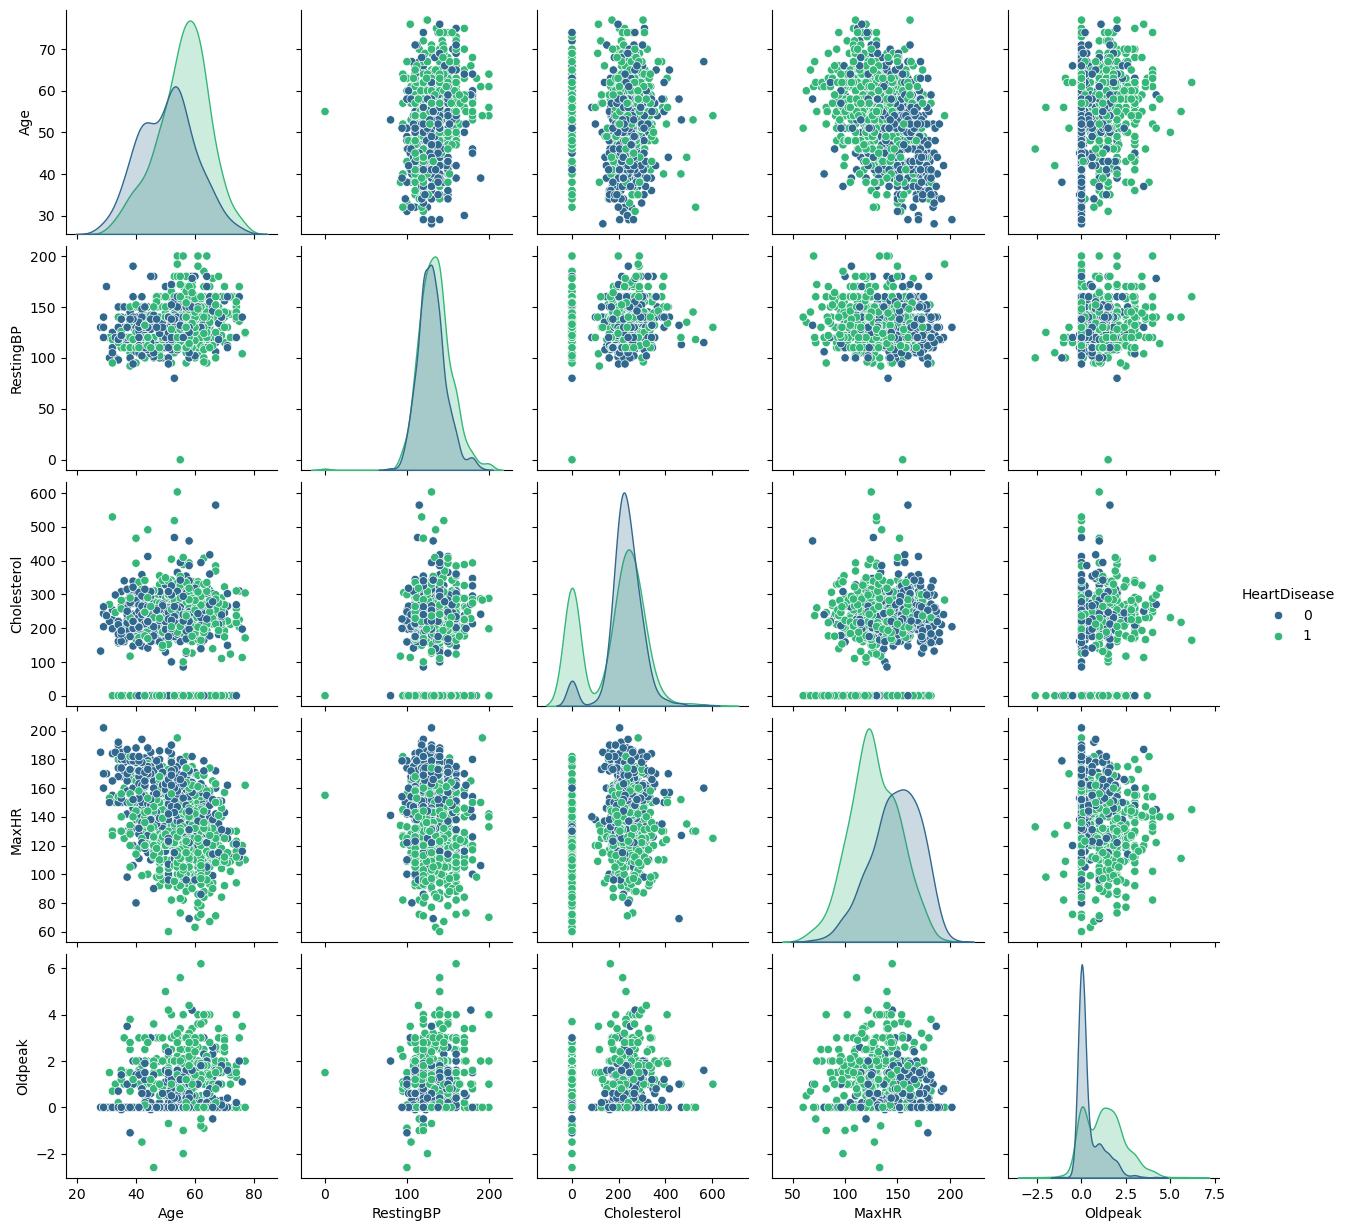

In [21]:
subset_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']
sns.pairplot(data[subset_features], hue='HeartDisease', palette='viridis')
plt.show()

In [22]:
## Polynomial Features → SelectKBest → PCA

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [24]:
data['ChestPainType'].value_counts()

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [25]:
data['RestingECG'].value_counts()

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

In [26]:
data['ExerciseAngina'].value_counts()

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

In [27]:
data['ST_Slope'].value_counts()

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

## Preprocession

In [28]:
data['ExerciseAngina'] = data['ExerciseAngina'].map({'N':0,'Y':1})

In [29]:
data['ExerciseAngina'].value_counts()

ExerciseAngina
0    547
1    371
Name: count, dtype: int64

In [30]:
cat_col = ['Sex', 'ChestPainType', 'RestingECG','ST_Slope']

In [31]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [32]:
data.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [33]:
(data == 0).sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS         704
RestingECG          0
MaxHR               0
ExerciseAngina    547
Oldpeak           368
ST_Slope            0
HeartDisease      410
dtype: int64

In [34]:
data['FastingBS'].value_counts()

FastingBS
0    704
1    214
Name: count, dtype: int64

In [35]:
data['Cholesterol'].value_counts()

Cholesterol
0      172
254     11
223     10
220     10
230      9
      ... 
392      1
316      1
153      1
466      1
131      1
Name: count, Length: 222, dtype: int64

In [36]:
data[['Cholesterol','RestingBP']].replace(0,np.nan,inplace=True)

In [37]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [38]:
cat_col

['Sex', 'ChestPainType', 'RestingECG', 'ST_Slope']

In [39]:
num_col = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [40]:
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Pipleline building

In [41]:
numerical_attribute = Pipeline( steps= [
    ('impute',SimpleImputer(strategy='mean')),
    ('Scaling',StandardScaler())
])

In [42]:
categorical_attribute = Pipeline( steps= [
    ('OHE',OneHotEncoder())
])

In [43]:
PreProcessing = ColumnTransformer( transformers= [
    ('numerical_data',numerical_attribute,num_col),
    ('categorical_data',categorical_attribute , cat_col)
    
])

In [44]:
preprocessed_pipeline = Pipeline( steps=[
    ('Preprocessing',PreProcessing)
])

In [45]:
preprocessed_pipeline

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('numerical_data',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('categorical_data',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ST_Slope'])]))])

In [46]:
x = data.drop(columns='HeartDisease')
y = data['HeartDisease']

In [47]:
x.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,M,ATA,140,289,0,Normal,172,0,0.0,Up
1,49,F,NAP,160,180,0,Normal,156,0,1.0,Flat
2,37,M,ATA,130,283,0,ST,98,0,0.0,Up
3,48,F,ASY,138,214,0,Normal,108,1,1.5,Flat
4,54,M,NAP,150,195,0,Normal,122,0,0.0,Up


In [48]:
preprocessed_data =  preprocessed_pipeline.fit_transform(x)

In [49]:
preprocessed_data_df = pd.DataFrame(preprocessed_data, columns= preprocessed_pipeline.get_feature_names_out())

In [50]:
preprocessed_data_df.head()

,numerical_data__Age,numerical_data__RestingBP,numerical_data__Cholesterol,numerical_data__MaxHR,numerical_data__Oldpeak,categorical_data__Sex_F,categorical_data__Sex_M,categorical_data__ChestPainType_ASY,categorical_data__ChestPainType_ATA,categorical_data__ChestPainType_NAP,categorical_data__ChestPainType_TA,categorical_data__RestingECG_LVH,categorical_data__RestingECG_Normal,categorical_data__RestingECG_ST,categorical_data__ST_Slope_Down,categorical_data__ST_Slope_Flat,categorical_data__ST_Slope_Up
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [51]:
preprocessed_pipeline.get_feature_names_out()

array(['numerical_data__Age', 'numerical_data__RestingBP',
       'numerical_data__Cholesterol', 'numerical_data__MaxHR',
       'numerical_data__Oldpeak', 'categorical_data__Sex_F',
       'categorical_data__Sex_M', 'categorical_data__ChestPainType_ASY',
       'categorical_data__ChestPainType_ATA',
       'categorical_data__ChestPainType_NAP',
       'categorical_data__ChestPainType_TA',
       'categorical_data__RestingECG_LVH',
       'categorical_data__RestingECG_Normal',
       'categorical_data__RestingECG_ST',
       'categorical_data__ST_Slope_Down',
       'categorical_data__ST_Slope_Flat', 'categorical_data__ST_Slope_Up'],
      dtype=object)

## Model implementation

In [52]:
x_train , x_test , y_train , y_test = train_test_split(x,y,random_state= 42 , test_size=0.2)

In [53]:
def results(x_train , x_test , y_train , y_test , model):
    model.fit(x_train,y_train)
    train_predict = model.predict(x_train)
    test_predict = model.predict(x_test)
    print('Train F1_score:',f1_score(y_train , train_predict))
    print('Test F1_score:',f1_score(y_test , test_predict))
    print('Train Accuracy_score:\n',accuracy_score(y_train , train_predict))
    print('Test Accuracy_score:\n',accuracy_score(y_test , test_predict))
    print('Train confusion_matrix:\n',confusion_matrix(y_train , train_predict))
    print('Test confusion_matrix:\n',confusion_matrix(y_test , test_predict))
    print('Train Classification_Report:\n',classification_report(y_train , train_predict))
    print('Test Classification_Report:\n',classification_report(y_test , test_predict))
    
    

# logistic regression

## 1

In [54]:
model_log_reg = Pipeline( steps=[
    ('Preprocessing',PreProcessing),
    ('Logistic_regression',LogisticRegression())
])

In [55]:
results(x_train , x_test , y_train , y_test , model_log_reg)

Train F1_score: 0.8728606356968215
Test F1_score: 0.8529411764705882
Train Accuracy_score:
 0.8583106267029973
Test Accuracy_score:
 0.8369565217391305
Train confusion_matrix:
 [[273  60]
 [ 44 357]]
Test confusion_matrix:
 [[67 10]
 [20 87]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       333
           1       0.86      0.89      0.87       401

    accuracy                           0.86       734
   macro avg       0.86      0.86      0.86       734
weighted avg       0.86      0.86      0.86       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82        77
           1       0.90      0.81      0.85       107

    accuracy                           0.84       184
   macro avg       0.83      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



## 2

In [56]:
model_log_reg_1 = Pipeline( steps=[
    ('Preprocessing',PreProcessing),
    ('Logistic_regression',LogisticRegression(penalty='l1' , solver= 'liblinear'))
])
#performance is not good

In [57]:
results(x_train , x_test , y_train , y_test , model_log_reg_1)

Train F1_score: 0.8714810281517748
Test F1_score: 0.848780487804878
Train Accuracy_score:
 0.8569482288828338
Test Accuracy_score:
 0.8315217391304348
Train confusion_matrix:
 [[273  60]
 [ 45 356]]
Test confusion_matrix:
 [[66 11]
 [20 87]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84       333
           1       0.86      0.89      0.87       401

    accuracy                           0.86       734
   macro avg       0.86      0.85      0.86       734
weighted avg       0.86      0.86      0.86       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81        77
           1       0.89      0.81      0.85       107

    accuracy                           0.83       184
   macro avg       0.83      0.84      0.83       184
weighted avg       0.84      0.83      0.83       184



 #### 2 has no improvemovement

## 3

In [58]:
model_log_reg_2 = Pipeline( steps=[
    ('Preprocessing',PreProcessing),
    ('poly',PolynomialFeatures(degree=2)),
    ('Logistic_regression',LogisticRegression())
])

In [59]:
results(x_train , x_test , y_train , y_test , model_log_reg_2)

Train F1_score: 0.8946078431372549
Test F1_score: 0.9142857142857143
Train Accuracy_score:
 0.8828337874659401
Test Accuracy_score:
 0.9021739130434783
Train confusion_matrix:
 [[283  50]
 [ 36 365]]
Test confusion_matrix:
 [[70  7]
 [11 96]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       333
           1       0.88      0.91      0.89       401

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89        77
           1       0.93      0.90      0.91       107

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



#### 3 has Improved compared to 1

## 4

In [60]:
model_log_reg_3 = Pipeline( steps=[
    ('Preprocessing',PreProcessing),
    ('poly',PolynomialFeatures(degree=2)),
    ('k_best',SelectKBest(f_classif , k=150)),
    ('Logistic_regression',LogisticRegression())
])

In [61]:
results(x_train , x_test , y_train , y_test , model_log_reg_3)

Train F1_score: 0.8968058968058968
Test F1_score: 0.9038461538461539
Train Accuracy_score:
 0.885558583106267
Test Accuracy_score:
 0.8913043478260869
Train confusion_matrix:
 [[285  48]
 [ 36 365]]
Test confusion_matrix:
 [[70  7]
 [13 94]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.87       333
           1       0.88      0.91      0.90       401

    accuracy                           0.89       734
   macro avg       0.89      0.88      0.88       734
weighted avg       0.89      0.89      0.89       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88        77
           1       0.93      0.88      0.90       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



#### 4 has no major chagge compared to 3 , 3 stands

#### 5 PCA

In [62]:
model_pca = Pipeline( steps=[
    ('Preprocessing',PreProcessing),
    ('pca',PCA(n_components=5)),
    ('Logistic_regression',LogisticRegression())
])

In [63]:
results(x_train , x_test , y_train , y_test , model_pca )

Train F1_score: 0.8402515723270441
Test F1_score: 0.8137254901960784
Train Accuracy_score:
 0.8269754768392371
Test Accuracy_score:
 0.7934782608695652
Train confusion_matrix:
 [[273  60]
 [ 67 334]]
Test confusion_matrix:
 [[63 14]
 [24 83]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       333
           1       0.85      0.83      0.84       401

    accuracy                           0.83       734
   macro avg       0.83      0.83      0.83       734
weighted avg       0.83      0.83      0.83       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.72      0.82      0.77        77
           1       0.86      0.78      0.81       107

    accuracy                           0.79       184
   macro avg       0.79      0.80      0.79       184
weighted avg       0.80      0.79      0.79       184



###### no improvement

In [64]:
model_PCA_1 = Pipeline( steps=[
    ('Preprocessing',PreProcessing),
    ('poly',PolynomialFeatures(degree=2)),
    ('k_best',SelectKBest(f_classif , k=150)),
    ('pca',PCA(n_components=58)),
    ('Logistic_regression',LogisticRegression())
])   


In [65]:
results(x_train , x_test , y_train , y_test , model_PCA_1 )

Train F1_score: 0.8929889298892989
Test F1_score: 0.919431279620853
Train Accuracy_score:
 0.8814713896457765
Test Accuracy_score:
 0.907608695652174
Train confusion_matrix:
 [[284  49]
 [ 38 363]]
Test confusion_matrix:
 [[70  7]
 [10 97]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       333
           1       0.88      0.91      0.89       401

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89        77
           1       0.93      0.91      0.92       107

    accuracy                           0.91       184
   macro avg       0.90      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184



#### have some improvement compared to previous results

## Random Forest

#### 1

In [66]:
model_RF = Pipeline( steps=[
    ('Preprocessing',PreProcessing),
    ('RF',RandomForestClassifier(n_estimators= 150 , max_features= 0.6 , min_samples_leaf=4 , min_samples_split= 4 , max_depth= 5))
])

In [67]:
results(x_train , x_test , y_train , y_test , model_RF)

Train F1_score: 0.9130434782608695
Test F1_score: 0.8962264150943396
Train Accuracy_score:
 0.9019073569482289
Test Accuracy_score:
 0.8804347826086957
Train confusion_matrix:
 [[284  49]
 [ 23 378]]
Test confusion_matrix:
 [[67 10]
 [12 95]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89       333
           1       0.89      0.94      0.91       401

    accuracy                           0.90       734
   macro avg       0.91      0.90      0.90       734
weighted avg       0.90      0.90      0.90       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



In [68]:
model_RF_1 = Pipeline( steps=[
    ('Preprocessing',PreProcessing),
    ('RF',RandomForestClassifier())
])

In [69]:
results(x_train , x_test , y_train , y_test , model_RF_1)

Train F1_score: 1.0
Test F1_score: 0.8857142857142857
Train Accuracy_score:
 1.0
Test Accuracy_score:
 0.8695652173913043
Train confusion_matrix:
 [[333   0]
 [  0 401]]
Test confusion_matrix:
 [[67 10]
 [14 93]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       333
           1       1.00      1.00      1.00       401

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85        77
           1       0.90      0.87      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



###### GSCV

In [70]:
param_grid = {
    'RF__n_estimators': [50, 100, 200],
    'RF__max_depth': [5, 10, 15],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4],

}

In [71]:
grid_search = GridSearchCV(model_RF_1, param_grid, cv=5, scoring='f1', n_jobs=-1)

In [72]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessing',
                                        ColumnTransformer(transformers=[('numerical_data',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('Scaling',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak']),
                                                                        ('categorical_data',
                                                                         Pipeline(steps=[('OHE',
                                                                                          OneHotEncoder())]),
                                                                         ['Sex',
                                                                          'ChestPainType',
                                                                          'RestingECG',
                                                                          'ST_Slope'])])),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RF__max_depth': [5, 10, 15],
                         'RF__min_samples_leaf': [1, 2, 4],
                         'RF__min_samples_split': [2, 5, 10],
                         'RF__n_estimators': [50, 100, 200]},
             scoring='f1')

In [73]:
model_RF_2 = Pipeline( steps=[
    ('Preprocessing',PreProcessing),
    ('RF',RandomForestClassifier(max_depth=5, min_samples_split=5))
])

In [74]:
results(x_train , x_test , y_train , y_test , model_RF_2)

Train F1_score: 0.9057971014492754
Test F1_score: 0.8846153846153846
Train Accuracy_score:
 0.8937329700272479
Test Accuracy_score:
 0.8695652173913043
Train confusion_matrix:
 [[281  52]
 [ 26 375]]
Test confusion_matrix:
 [[68  9]
 [15 92]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88       333
           1       0.88      0.94      0.91       401

    accuracy                           0.89       734
   macro avg       0.90      0.89      0.89       734
weighted avg       0.90      0.89      0.89       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        77
           1       0.91      0.86      0.88       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



In [75]:
PreProcessing1 = ColumnTransformer( transformers= [
    ('numerical_data',numerical_attribute,num_col)
    
])

In [76]:
model_RF_2 = Pipeline( steps=[
    ('Preprocessing',PreProcessing1),
    ('RF',RandomForestClassifier())
])

In [77]:
results(x_train , x_test , y_train , y_test , model_RF_2)

Train F1_score: 1.0
Test F1_score: 0.7623762376237624
Train Accuracy_score:
 1.0
Test Accuracy_score:
 0.7391304347826086
Train confusion_matrix:
 [[333   0]
 [  0 401]]
Test confusion_matrix:
 [[59 18]
 [30 77]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       333
           1       1.00      1.00      1.00       401

    accuracy                           1.00       734
   macro avg       1.00      1.00      1.00       734
weighted avg       1.00      1.00      1.00       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.66      0.77      0.71        77
           1       0.81      0.72      0.76       107

    accuracy                           0.74       184
   macro avg       0.74      0.74      0.74       184
weighted avg       0.75      0.74      0.74       184



In [78]:
grid_search = GridSearchCV(model_RF_2, param_grid, cv=5, scoring='f1', n_jobs=-1)

In [79]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessing',
                                        ColumnTransformer(transformers=[('numerical_data',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('Scaling',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak'])])),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RF__max_depth': [5, 10, 15],
                         'RF__min_samples_leaf': [1, 2, 4],
                         'RF__min_samples_split': [2, 5, 10],
                         'RF__n_estimators': [50, 100, 200]},
             scoring='f1')

## boositing


In [80]:
model_ADA = Pipeline( steps=[
    ('Preprocessing',PreProcessing1),
    ('ada_b',xgboost.XGBClassifier(estimator=RandomForestClassifier(max_depth=1), n_estimators=50, learning_rate=0.1, random_state=42))
])

In [81]:
results(x_train , x_test , y_train , y_test , model_ADA)

Train F1_score: 0.9306431273644389
Test F1_score: 0.7766990291262136
Train Accuracy_score:
 0.9250681198910081
Test Accuracy_score:
 0.75
Train confusion_matrix:
 [[310  23]
 [ 32 369]]
Test confusion_matrix:
 [[58 19]
 [27 80]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       333
           1       0.94      0.92      0.93       401

    accuracy                           0.93       734
   macro avg       0.92      0.93      0.92       734
weighted avg       0.93      0.93      0.93       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.68      0.75      0.72        77
           1       0.81      0.75      0.78       107

    accuracy                           0.75       184
   macro avg       0.75      0.75      0.75       184
weighted avg       0.76      0.75      0.75       184



In [82]:
param_grid = {
    'RF__n_estimators': [50, 100, 200],
    'RF__max_depth': [5, 10, 15],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4],
    'RF__max_features':['sqrt','log2', None],
    'RF__bootstrap':[True , False]
}

In [83]:
grid_search = GridSearchCV(model_RF_2, param_grid, cv=5, scoring='f1', n_jobs=-1)

In [84]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessing',
                                        ColumnTransformer(transformers=[('numerical_data',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer()),
                                                                                         ('Scaling',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR',
                                                                          'Oldpeak'])])),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RF__bootstrap': [True, False],
                         'RF__max_depth': [5, 10, 15],
                         'RF__max_features': ['sqrt', 'log2', None],
                         'RF__min_samples_leaf': [1, 2, 4],
                         'RF__min_samples_split': [2, 5, 10],
                         'RF__n_estimators': [50, 100, 200]},
             scoring='f1')

In [85]:
model_ADA1 = Pipeline( steps=[
    ('Preprocessing',PreProcessing1),
    ('ada_b',RandomForestClassifier(bootstrap=False, max_depth=5, max_features='log2',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=50))
])

In [86]:
results(x_train , x_test , y_train , y_test , model_ADA1)

Train F1_score: 0.8417085427135679
Test F1_score: 0.7729468599033816
Train Accuracy_score:
 0.8283378746594006
Test Accuracy_score:
 0.7445652173913043
Train confusion_matrix:
 [[273  60]
 [ 66 335]]
Test confusion_matrix:
 [[57 20]
 [27 80]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81       333
           1       0.85      0.84      0.84       401

    accuracy                           0.83       734
   macro avg       0.83      0.83      0.83       734
weighted avg       0.83      0.83      0.83       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71        77
           1       0.80      0.75      0.77       107

    accuracy                           0.74       184
   macro avg       0.74      0.74      0.74       184
weighted avg       0.75      0.74      0.75       184



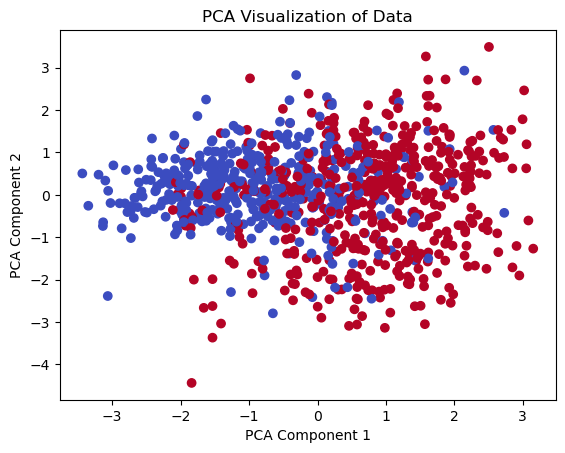

In [87]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(preprocessed_data_df)  

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of Data")
plt.show()

## NB


In [88]:
model_NB = Pipeline( steps=[
    ('Preprocessing',PreProcessing1),
    ('NB',GaussianNB())
])

In [89]:
results(x_train , x_test , y_train , y_test , model_NB)

Train F1_score: 0.7959442332065906
Test F1_score: 0.7707317073170732
Train Accuracy_score:
 0.7806539509536785
Test Accuracy_score:
 0.7445652173913043
Train confusion_matrix:
 [[259  74]
 [ 87 314]]
Test confusion_matrix:
 [[58 19]
 [28 79]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76       333
           1       0.81      0.78      0.80       401

    accuracy                           0.78       734
   macro avg       0.78      0.78      0.78       734
weighted avg       0.78      0.78      0.78       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71        77
           1       0.81      0.74      0.77       107

    accuracy                           0.74       184
   macro avg       0.74      0.75      0.74       184
weighted avg       0.75      0.74      0.75       184



In [90]:
model_NB_1 = Pipeline( steps=[
    ('Preprocessing',PreProcessing1),
    ('k_best',SelectKBest(f_classif , k=150)),
    ('NB',GaussianNB())
])

In [91]:
results(x_train , x_test , y_train , y_test , model_NB_1)

Train F1_score: 0.7959442332065906
Test F1_score: 0.7707317073170732
Train Accuracy_score:
 0.7806539509536785
Test Accuracy_score:
 0.7445652173913043
Train confusion_matrix:
 [[259  74]
 [ 87 314]]
Test confusion_matrix:
 [[58 19]
 [28 79]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76       333
           1       0.81      0.78      0.80       401

    accuracy                           0.78       734
   macro avg       0.78      0.78      0.78       734
weighted avg       0.78      0.78      0.78       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71        77
           1       0.81      0.74      0.77       107

    accuracy                           0.74       184
   macro avg       0.74      0.75      0.74       184
weighted avg       0.75      0.74      0.75       184



####  KNN

In [92]:
model_KNN_1 = Pipeline( steps=[
    ('Preprocessing',PreProcessing1),
    ('KNN',KNeighborsClassifier())
])

In [93]:
results(x_train , x_test , y_train , y_test , model_KNN_1)

Train F1_score: 0.8197969543147208
Test F1_score: 0.7843137254901961
Train Accuracy_score:
 0.8065395095367848
Test Accuracy_score:
 0.7608695652173914
Train confusion_matrix:
 [[269  64]
 [ 78 323]]
Test confusion_matrix:
 [[60 17]
 [27 80]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       333
           1       0.83      0.81      0.82       401

    accuracy                           0.81       734
   macro avg       0.80      0.81      0.81       734
weighted avg       0.81      0.81      0.81       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.69      0.78      0.73        77
           1       0.82      0.75      0.78       107

    accuracy                           0.76       184
   macro avg       0.76      0.76      0.76       184
weighted avg       0.77      0.76      0.76       184



In [94]:
results(x_train , x_test , y_train , y_test , model_PCA_1 )

Train F1_score: 0.8943488943488943
Test F1_score: 0.9142857142857143
Train Accuracy_score:
 0.8828337874659401
Test Accuracy_score:
 0.9021739130434783
Train confusion_matrix:
 [[284  49]
 [ 37 364]]
Test confusion_matrix:
 [[70  7]
 [11 96]]
Train Classification_Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       333
           1       0.88      0.91      0.89       401

    accuracy                           0.88       734
   macro avg       0.88      0.88      0.88       734
weighted avg       0.88      0.88      0.88       734

Test Classification_Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.89        77
           1       0.93      0.90      0.91       107

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



In [95]:
joblib.dump(model_PCA_1, "Final_predication_PCA_LR.pkl")

['Final_predication_PCA_LR.pkl']

In [96]:
loaded_model = joblib.load("Final_predication_PCA_LR.pkl")

In [97]:
loaded_model

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('numerical_data',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR',
                                                   'Oldpeak']),
                                                 ('categorical_data',
                                                  Pipeline(steps=[('OHE',
                                                                   OneHotEncoder())]),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ST_Slope'])])),
                ('poly', PolynomialFeatures()), ('k_best', SelectKBest(k=150)),
                ('pca', PCA(n_components=58)),
                ('Logistic_regression', LogisticRegression())])

In [98]:
! python --version

Python 3.12.7


In [103]:
data.iloc[0]

Age                   40
Sex                    M
ChestPainType        ATA
RestingBP            140
Cholesterol          289
FastingBS              0
RestingECG        Normal
MaxHR                172
ExerciseAngina         0
Oldpeak              0.0
ST_Slope              Up
HeartDisease           0
Name: 0, dtype: object

In [104]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,0,0.0,Up,0
